# Common Preprocessing Steps for NLP
1. Stopwords
2. Tokenization
3. Stemming and Lemmatization
4. Unicode Normalization

## **1. Stopwords**
Stopwords are the most common words in any natural language. For the purpose of analyzing text data and building NLP models, these stopwords might not add much value to the meaning of the document. Generally, the most common words used in a text are “the”, “is”, “in”, “for”, “where”, “when”, “to”, “at” etc.


## 2. Tokenization
A token is a single unit of information that we usually feed into the model. 
There can be different types tokens:
> - A word
> - Part of a word
> - A single character
> - Punctuation mark
> - Special token like <URL>, or <NAME>
> - Model-specific special tokens, like [CLS] and [SEP] for BERT 
>  - For BERT there are 5 Special Model Tokens

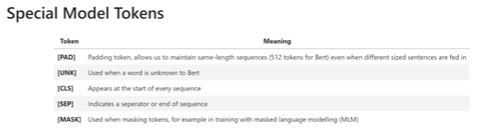

## Stemming and Lemmatization
Stemming and lemmatization are methods used by search engines and chatbots to analyze the meaning behind a word. Stemming uses the stem of the word means, while lemmatization uses the context in which the word is being used. 
> - Stemming 

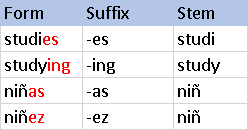

> - Lemmatization

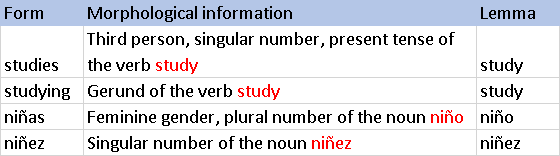

## 4. Unicode Normalization
In computer text, we have lot of characters such as unicode character and some of these characters depend on the next character. So it's quite difficult to feed them into the model directly as it'll have affect on the model. 

There're two different forms of characters that are different but also equivalent. 


1. Canonical Equivalence:  These are quite hard to spot as they're identical while rendered but in reality is completly different characters

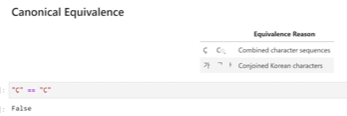

2. Compatibility Equivalence: These are quite easy to differentiate and there also have the same meaning but they're Unicodes are different even though they've similar meaning.

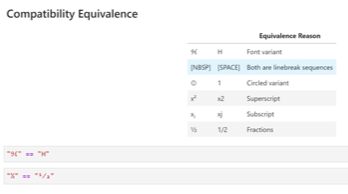

In Unicode Normalization, we have two different directions for how we can transform our characters.

1. Decomposition
2. Composition

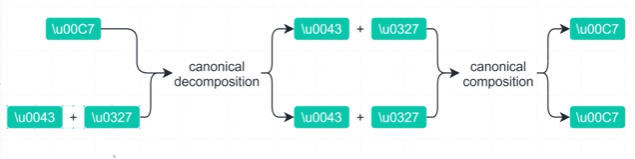

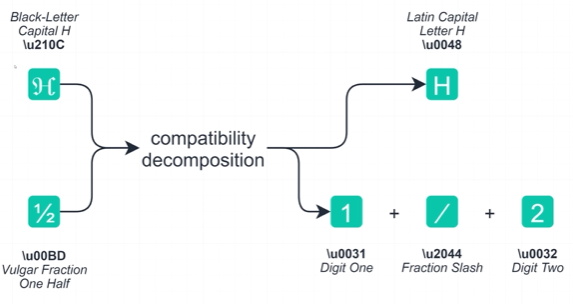

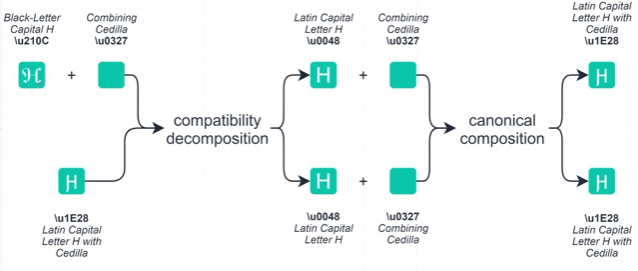

These Decompostion and Composition methods can be broken down into four Normal Forms:

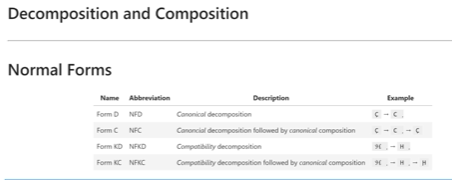

In [23]:
import unicodedata
# Canonical 
c_with_cedilla = "\u00C7"
c_plus_cedilla = "\u0043\u0327"
unicodedata.normalize("NFD", c_with_cedilla) == c_plus_cedilla # True
unicodedata.normalize("NFC", c_with_cedilla) == c_plus_cedilla # False
unicodedata.normalize("NFC", c_with_cedilla) == unicodedata.normalize("NFC", c_plus_cedilla) # True in all case >>>>> Better


True

In [32]:
# Compatible
"ℋ" == "H" # False
unicodedata.normalize("NFKD", "ℋ") == "H" # True
fancy_h_with_cedilla = "\u210B\u0327" # ℋ̧
h_with_cedilla = "\u1e28" # Ḩ
fancy_h_with_cedilla == h_with_cedilla # False
unicodedata.normalize("NFKD", fancy_h_with_cedilla) == h_with_cedilla # False
unicodedata.normalize("NFKC", fancy_h_with_cedilla) == h_with_cedilla # True
unicodedata.normalize("NFKC", h_with_cedilla) == fancy_h_with_cedilla # False
unicodedata.normalize("NFKC", h_with_cedilla) == unicodedata.normalize("NFKC", fancy_h_with_cedilla) # True in all case for both cannonical and compatible >>>>> Best


True

In [28]:
fancy_h_with_cedilla

'ℋ̧'

In [2]:
# Here I'll use the kaggle dataset from Commolit Readability Competition https://www.kaggle.com/c/commonlitreadabilityprize/data
# At first let me Mount my drive to get the dataset
HOME_PATH = "/content"
%cd "$HOME_PATH"
from google.colab import drive 
drive.mount("/content/drive")
# Kaggle dataset path
DATASET_PATH = "/content/drive/My Drive/Data Science/data/commonlitreadabilityprize/"

/content
Mounted at /content/drive


In [13]:
### Import Some Libraries
import pandas as pd
import re
from typing import Tuple, List

# Preprocessing Libraries
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.tokenize import sent_tokenize, word_tokenize 
from nltk.corpus import stopwords, wordnet
from nltk import pos_tag

# Spacy vs NLTK https://www.quora.com/What-are-the-advantages-of-Spacy-vs-NLTK
import spacy

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [4]:
!pip install rich
from rich.console import Console
from rich import print

     |████████████████████████████████| 215kB 3.8MB/s 
     |████████████████████████████████| 51kB 5.6MB/s 


In [5]:
# Read in data
train_df = pd.read_csv(f"{DATASET_PATH}train.csv")
test_df = pd.read_csv(f"{DATASET_PATH}test.csv")

In [6]:
# Print out the first few rows of the data
train_df.head()

,id,url_legal,license,excerpt,target,standard_error
0,c12129c31,NaN,NaN,When the young people returned to the ballroom...,-0.340259,0.464009
1,85aa80a4c,NaN,NaN,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,0.480805
2,b69ac6792,NaN,NaN,"As Roger had predicted, the snow departed as q...",-0.580118,0.476676
3,dd1000b26,NaN,NaN,And outside before the palace a great garden w...,-1.054013,0.450007
4,37c1b32fb,NaN,NaN,Once upon a time there were Three Bears who li...,0.247197,0.510845


In [7]:
# Let's have a look at some of the text data
train_df.loc[0, 'excerpt']

'When the young people returned to the ballroom, it presented a decidedly changed appearance. Instead of an interior scene, it was a winter landscape.\nThe floor was covered with snow-white canvas, not laid on smoothly, but rumpled over bumps and hillocks, like a real snow field. The numerous palms and evergreens that had decorated the room, were powdered with flour and strewn with tufts of cotton, like snow. Also diamond dust had been lightly sprinkled on them, and glittering crystal icicles hung from the branches.\nAt each end of the room, on the wall, hung a beautiful bear-skin rug.\nThese rugs were for prizes, one for the girls and one for the boys. And this was the game.\nThe girls were gathered at one end of the room and the boys at the other, and one end was called the North Pole, and the other the South Pole. Each player was given a small flag which they were to plant on reaching the Pole.\nThis would have been an easy matter, but each traveller was obliged to wear snowshoes.'

## Preprocessing the data
Let's write a reusable function for preprocessing.

In [14]:
# Clean and Tokenize all the excerpts
def extract_characters_only(excerpt:str) -> str:
    return re.sub("[^a-zA-Z]", " ", excerpt) # Remove everything without letters

def clean_excerpts(excerpt:str) -> str:
    #print(type(excerpt))
    excerpt_cleaned = extract_characters_only(excerpt)
    #print(type(excerpt_cleaned))
    excerpt_cleaned = excerpt_cleaned.lower() # Convert all words into lowercase
    excerpt_cleaned = word_tokenize(excerpt_cleaned) # Tokenize all words
    excerpt_cleaned = [word for word in excerpt_cleaned if not word in set(stopwords.words("english"))] # Remove stopwords from the list
    excerpt_cleaned = [nltk.WordNetLemmatizer().lemmatize(word, wordnet.VERB) for word in excerpt_cleaned] # Lemmatize all the words
    excerpt_cleaned = " ".join(excerpt_cleaned) # Join all the words back as string from array of strings
    return excerpt_cleaned


In [15]:
from copy import deepcopy
df_processed = deepcopy(train_df)
# Clean and tokenize Excerpts as Excerpt_Cleaned # "excerpts" > "excerpt_cleaned"
df_processed['excerpt_cleaned'] = df_processed['excerpt'].apply(lambda x: clean_excerpts(x))
    

In [16]:
print('>>>>>>>>>> Before Preprocessing')
print(df_processed.loc[0, 'excerpt'])
print('>>>>>>>>>> After Preprocessing')
print(df_processed.loc[0, 'excerpt_cleaned'])

>>>>>>>>>> Before Preprocessing

When the young people returned to the ballroom, it presented a decidedly changed appearance. 
Instead of an interior scene, it was a winter landscape.
The floor was covered with snow-white canvas, not laid on smoothly, but rumpled over bumps 
and hillocks, like a real snow field. The numerous palms and evergreens that had decorated 
the room, were powdered with flour and strewn with tufts of cotton, like snow. Also diamond 
dust had been lightly sprinkled on them, and glittering crystal icicles hung from the 
branches.
At each end of the room, on the wall, hung a beautiful bear-skin rug.
These rugs were for prizes, one for the girls and one for the boys. And this was the game.
The girls were gathered at one end of the room and the boys at the other, and one end was 
called the North Pole, and the other the South Pole. Each player was given a small flag which
they were to plant on reaching the Pole.
This would have been an easy matter, but each traveller was obliged to wear snowshoes.

>>>>>>>>>> After Preprocessing

young people return ballroom present decidedly change appearance instead interior scene 
winter landscape floor cover snow white canvas lay smoothly rumple bump hillocks like real 
snow field numerous palm evergreens decorate room powder flour strew tufts cotton like snow 
also diamond dust lightly sprinkle glitter crystal icicles hang branch end room wall hang 
beautiful bear skin rug rugs prize one girls one boys game girls gather one end room boys one
end call north pole south pole player give small flag plant reach pole would easy matter 
traveller oblige wear snowshoe